In this module, I used CatBoost model to predcit the response of whether the policyholders from past year will be interested in Vehicle Insurance provided by the company.CatBoost is an open-source software library developed by Yandex. It provides a gradient boosting framework which attempts to solve for Categorical features using a permutation driven alternative compared to the classical algorithm. [wiki](https://en.wikipedia.org/wiki/Catboost)
The model was able to achieve 85% of accuracy.


Our client is an Insurance company that has provided Health Insurance to its customers now they need your help in building a model to predict whether the policyholders (customers) from past year will also be interested in Vehicle Insurance provided by the company.



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import StandardScaler ,MinMaxScaler
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix,plot_roc_curve

In [2]:
train=pd.read_csv('/Users/nischal/Desktop/Git Hub Projects/Insurance Cross Sell/train.csv')
test=pd.read_csv('/Users/nischal/Desktop/Git Hub Projects/Insurance Cross Sell/test.csv')

In [3]:
train.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [4]:
train.shape

(381109, 12)

In [5]:
train.isna().any().sum()

0

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   Gender                381109 non-null  object 
 2   Age                   381109 non-null  int64  
 3   Driving_License       381109 non-null  int64  
 4   Region_Code           381109 non-null  float64
 5   Previously_Insured    381109 non-null  int64  
 6   Vehicle_Age           381109 non-null  object 
 7   Vehicle_Damage        381109 non-null  object 
 8   Annual_Premium        381109 non-null  float64
 9   Policy_Sales_Channel  381109 non-null  float64
 10  Vintage               381109 non-null  int64  
 11  Response              381109 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 34.9+ MB


In [7]:
train['Gender'].value_counts()

Male      206089
Female    175020
Name: Gender, dtype: int64

In [8]:
train['Vehicle_Age'].value_counts()

1-2 Year     200316
< 1 Year     164786
> 2 Years     16007
Name: Vehicle_Age, dtype: int64

In [9]:
train['Vehicle_Damage'].value_counts()

Yes    192413
No     188696
Name: Vehicle_Damage, dtype: int64

In [10]:
train.columns

Index(['id', 'Gender', 'Age', 'Driving_License', 'Region_Code',
       'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage', 'Response'],
      dtype='object')

In [11]:
train['Response'].value_counts()

0    334399
1     46710
Name: Response, dtype: int64

In [12]:
train.nunique()

id                      381109
Gender                       2
Age                         66
Driving_License              2
Region_Code                 53
Previously_Insured           2
Vehicle_Age                  3
Vehicle_Damage               2
Annual_Premium           48838
Policy_Sales_Channel       155
Vintage                    290
Response                     2
dtype: int64

In [13]:
train.groupby('Response').count()['id']

Response
0    334399
1     46710
Name: id, dtype: int64

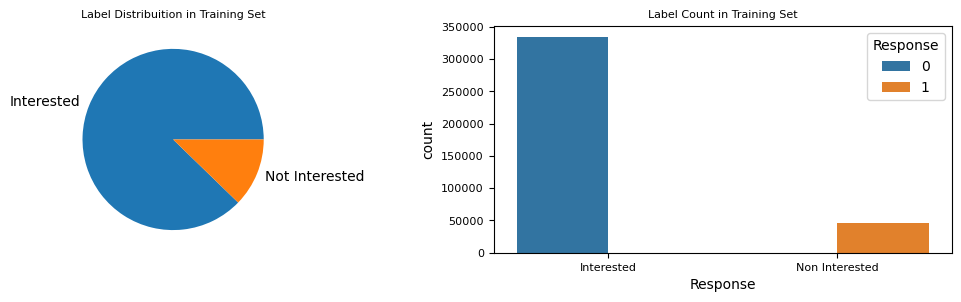

In [14]:
fig,ax=plt.subplots(ncols=2,figsize=(13,3),dpi=100)
plt.tight_layout

train.groupby('Response').count()['id'].plot(kind='pie',ax=ax[0],labels=['Interested', 'Not Interested'])
sns.countplot(x=train['Response'],hue=train['Response'],ax=ax[1])
ax[0].set_ylabel('')
ax[0].set_ylabel('')
ax[1].set_xticklabels(['Interested','Non Interested'])
ax[0].tick_params(axis='x',labelsize=8)
ax[0].tick_params(axis='y',labelsize=8)
ax[1].tick_params(axis='x',labelsize=8)
ax[1].tick_params(axis='y',labelsize=8)

ax[0].set_title('Label Distribuition in Training Set',fontsize=8)
ax[1].set_title('Label Count in Training Set', fontsize=8)
plt.show()

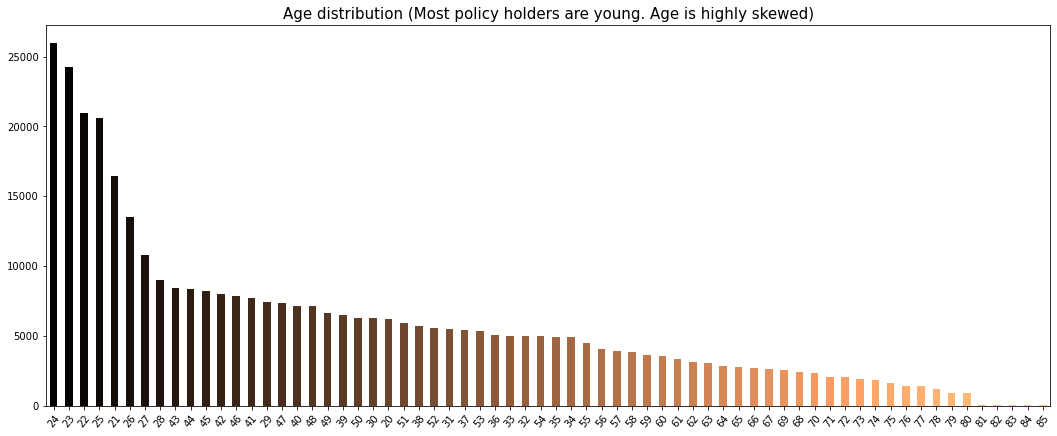

In [15]:
plt.rcParams['figure.figsize']=(18,7)
color=plt.cm.copper(np.linspace(0,1,66))
train['Age'].value_counts().head(66).plot.bar(color=color)
plt.title('Age distribution (Most policy holders are young. Age is highly skewed)',fontsize=15)
plt.xticks(rotation=50)
plt.show()

In [16]:
train['type']='train'
test['type']='test'

In [17]:
master_data=pd.concat([train,test])

In [18]:
master_data.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,type
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1.0,train
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0.0,train
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1.0,train
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0.0,train
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0.0,train


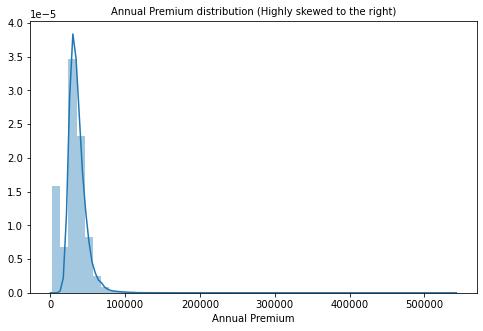

In [19]:
plt.figure(figsize=(8,5))
sns.distplot(master_data['Annual_Premium'])
plt.title('Annual Premium distribution (Highly skewed to the right)', fontsize=10)
plt.xlabel('Annual Premium')
plt.show()

In [20]:
master_data.groupby('Gender').count()['id']

Gender
Female    233821
Male      274325
Name: id, dtype: int64

In [21]:
master_data.loc[(master_data['Gender']=='Male'),'Age']

0         44
1         76
2         47
3         21
6         23
          ..
127029    64
127031    21
127034    21
127035    71
127036    41
Name: Age, Length: 274325, dtype: int64

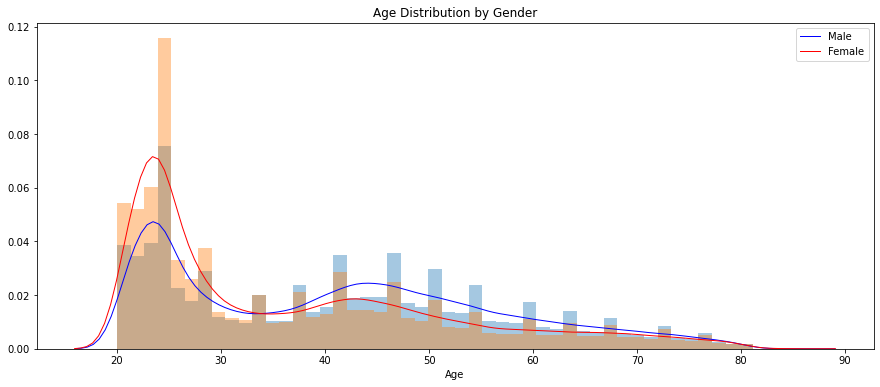

In [22]:
plt.figure(figsize=(15,6))
sns.distplot(master_data.loc[(master_data['Gender']=='Male'),'Age'], kde_kws={'color':'b','lw':1,'label':'Male'})
sns.distplot(master_data.loc[(master_data['Gender']=='Female'),'Age'],kde_kws={'color':'r','lw':1,'label':'Female'})
plt.title('Age Distribution by Gender')
plt.show()

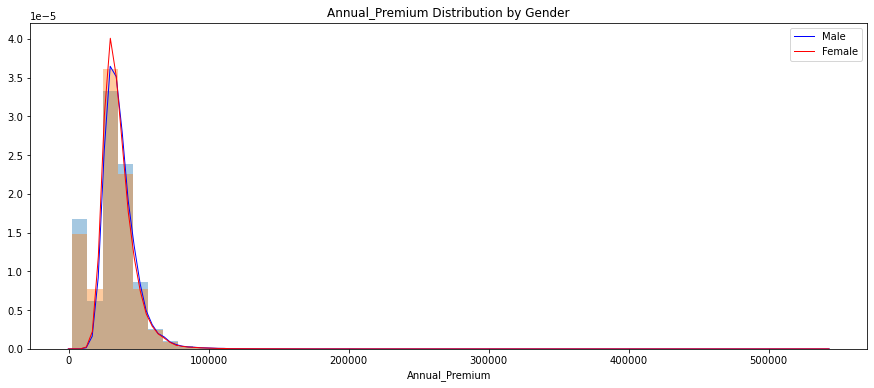

In [23]:
plt.figure(figsize=(15,6))
sns.distplot(master_data.loc[(master_data['Gender']=='Male'),'Annual_Premium'], kde_kws={'color':'b','lw':1,'label':'Male'})
sns.distplot(master_data.loc[(master_data['Gender']=='Female'),'Annual_Premium'],kde_kws={'color':'r','lw':1,'label':'Female'})
plt.title('Annual_Premium Distribution by Gender')
plt.show()

In [24]:
master_data['Vehicle_Age'].unique()

array(['> 2 Years', '1-2 Year', '< 1 Year'], dtype=object)

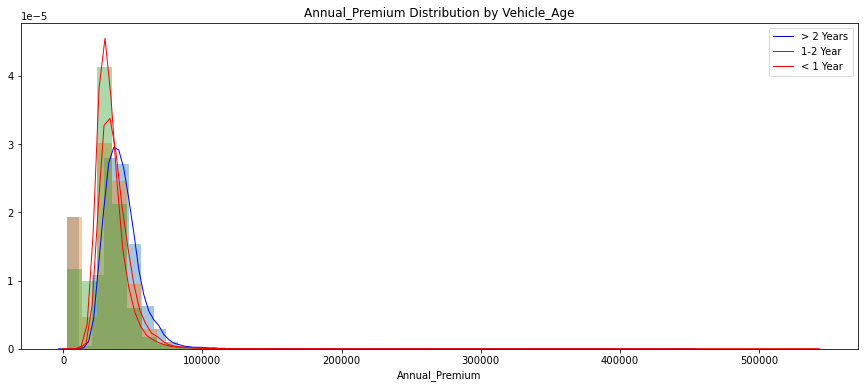

In [25]:
plt.figure(figsize=(15,6))
sns.distplot(master_data.loc[(master_data['Vehicle_Age']=='> 2 Years'),'Annual_Premium'], kde_kws={'color':'b','lw':1,'label':'> 2 Years'})
sns.distplot(master_data.loc[(master_data['Vehicle_Age']=='1-2 Year'),'Annual_Premium'],kde_kws={'color':'r','lw':1,'label':'1-2 Year'})
sns.distplot(master_data.loc[(master_data['Vehicle_Age']=='< 1 Year'),'Annual_Premium'],kde_kws={'color':'r','lw':1,'label':'< 1 Year'})
plt.title('Annual_Premium Distribution by Vehicle_Age')
plt.show()

<AxesSubplot:xlabel='Annual_Premium'>

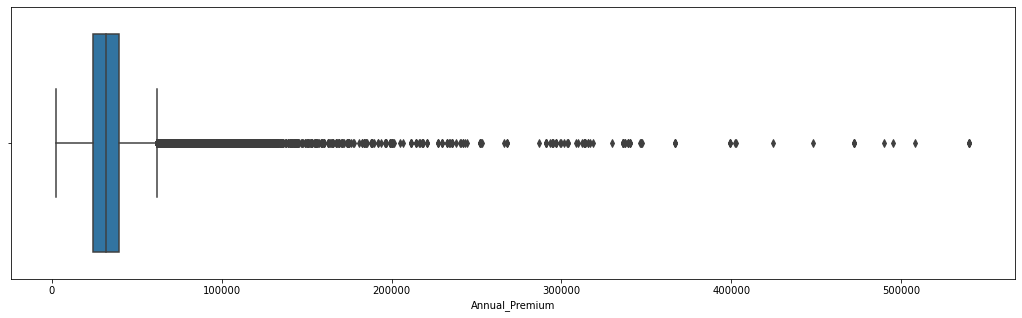

In [26]:
plt.figure(figsize=(18,5))
sns.boxplot(master_data['Annual_Premium'])


Feature Engineering

In [27]:
for col in train.columns[~(train.columns.isin(['age','id','region_code','annual_premium','policy_sales_channel','policy_sales_channel','vintage']))].tolist():
                         print(f'Unique Values --> + {col}, :, {len(train[col].unique())}: ,{train[col].unique()}')
                         

Unique Values --> + Gender, :, 2: ,['Male' 'Female']
Unique Values --> + Age, :, 66: ,[44 76 47 21 29 24 23 56 32 41 71 37 25 42 60 65 49 34 51 26 57 79 48 45
 72 30 54 27 38 22 78 20 39 62 58 59 63 50 67 77 28 69 52 31 33 43 36 53
 70 46 55 40 61 75 64 35 66 68 74 73 84 83 81 80 82 85]
Unique Values --> + Driving_License, :, 2: ,[1 0]
Unique Values --> + Region_Code, :, 53: ,[28.  3. 11. 41. 33.  6. 35. 50. 15. 45.  8. 36. 30. 26. 16. 47. 48. 19.
 39. 23. 37.  5. 17.  2.  7. 29. 46. 27. 25. 13. 18. 20. 49. 22. 44.  0.
  9. 31. 12. 34. 21. 10. 14. 38. 24. 40. 43. 32.  4. 51. 42.  1. 52.]
Unique Values --> + Previously_Insured, :, 2: ,[0 1]
Unique Values --> + Vehicle_Age, :, 3: ,['> 2 Years' '1-2 Year' '< 1 Year']
Unique Values --> + Vehicle_Damage, :, 2: ,['Yes' 'No']
Unique Values --> + Annual_Premium, :, 48838: ,[ 40454.  33536.  38294. ...  20706. 101664.  69845.]
Unique Values --> + Policy_Sales_Channel, :, 155: ,[ 26. 152. 160. 124.  14.  13.  30. 156. 163. 157. 122.  19.  22.  1

In [28]:
master_data['Driving_License'].unique()


array([1, 0])

In [29]:
master_data.columns
master_data['Gender']

0           Male
1           Male
2           Male
3           Male
4         Female
           ...  
127032    Female
127033    Female
127034      Male
127035      Male
127036      Male
Name: Gender, Length: 508146, dtype: object

In [30]:
Gender = {'Male': 0, 'Female': 1}
Driving_License = {0: 0, 1: 1}
Previously_Insured = {0: 1, 1: 0}
Vehicle_Age = {'> 2 Years': 2, '1-2 Year': 1, '< 1 Year': 0}
Vehicle_Damage = {'Yes': 1, 'No': 0}

master_data['Gender'] = master_data['Gender'].map(Gender)
master_data['Driving_License'] = master_data['Driving_License'].map(Driving_License)
master_data['Previously_Insured'] = master_data['Previously_Insured'].map(Previously_Insured)
master_data['Vehicle_Age'] = master_data['Vehicle_Age'].map(Vehicle_Age)
master_data['Vehicle_Damage'] = master_data['Vehicle_Damage'].map(Vehicle_Damage)

master_data['Policy_Sales_Channel'] = master_data['Policy_Sales_Channel'].apply(lambda x: np.int(x))
master_data['Region_Code'] = master_data['Region_Code'].apply(lambda x: np.int(x))

master_data.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,type
0,1,0,44,1,28,1,2,1,40454.0,26,217,1.0,train
1,2,0,76,1,3,1,1,0,33536.0,26,183,0.0,train
2,3,0,47,1,28,1,2,1,38294.0,26,27,1.0,train
3,4,0,21,1,11,0,0,0,28619.0,152,203,0.0,train
4,5,1,29,1,41,0,0,0,27496.0,152,39,0.0,train


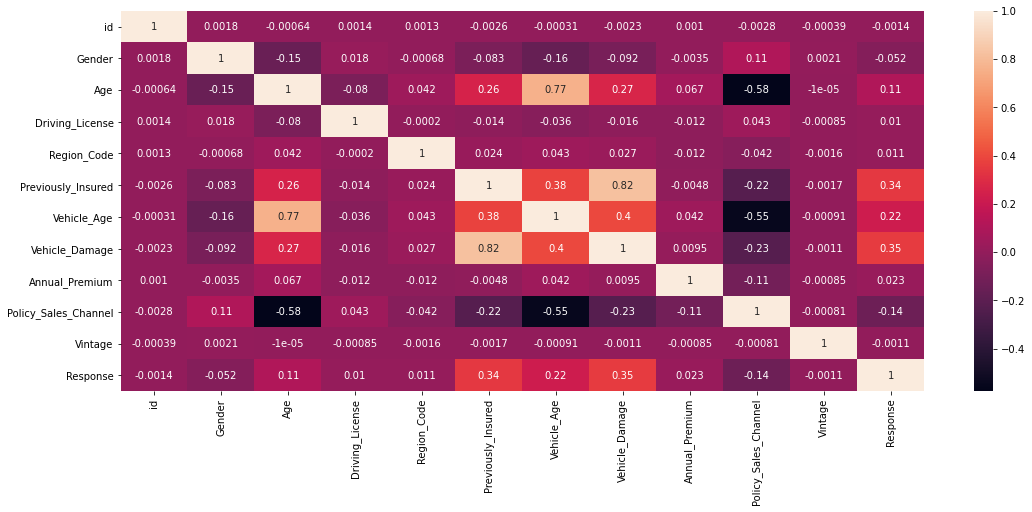

In [31]:
corrMatrix=master_data.corr()
sns.heatmap(corrMatrix,annot=True)
plt.show()

In [32]:
numerical_cols=['Age','Vintage']
cat_col=['Gender', 'Driving_License', 'Region_Code', 'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Policy_Sales_Channel']
ss=StandardScaler()
master_data[numerical_cols]=ss.fit_transform(master_data[numerical_cols])
mm=MinMaxScaler()
master_data[['Annual_Premium']]=mm.fit_transform(master_data[['Annual_Premium']])





In [33]:
master_data.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,type
0,1,0,0.334938,1,28,1,2,1,0.070366,26,0.748905,1.0,train
1,2,0,2.399432,1,3,1,1,0,0.057496,26,0.342540,0.0,train
2,3,0,0.528484,1,28,1,2,1,0.066347,26,-1.521956,1.0,train
3,4,0,-1.148918,1,11,0,0,0,0.048348,152,0.581578,0.0,train
4,5,1,-0.632794,1,41,0,0,0,0.046259,152,-1.378534,0.0,train


In [34]:
train_data=master_data.loc[(master_data['type']=='train')]

In [35]:
test_data=master_data.loc[(master_data['type']=='test')]

In [36]:
test_data.shape, train_data.shape

((127037, 13), (381109, 13))

In [37]:
for col in cat_col:
    test_data[col]=test_data[col].astype('str')

/Applications/Anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [38]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 127037 entries, 0 to 127036
Data columns (total 13 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    127037 non-null  int64  
 1   Gender                127037 non-null  object 
 2   Age                   127037 non-null  float64
 3   Driving_License       127037 non-null  object 
 4   Region_Code           127037 non-null  object 
 5   Previously_Insured    127037 non-null  object 
 6   Vehicle_Age           127037 non-null  object 
 7   Vehicle_Damage        127037 non-null  object 
 8   Annual_Premium        127037 non-null  float64
 9   Policy_Sales_Channel  127037 non-null  object 
 10  Vintage               127037 non-null  float64
 11  Response              0 non-null       float64
 12  type                  127037 non-null  object 
dtypes: float64(4), int64(1), object(8)
memory usage: 13.6+ MB


In [39]:
for col in cat_col:
    train_data[col]=train_data[col].astype('str')

/Applications/Anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [40]:
train_data=train_data.drop('Vintage',axis=1)

In [41]:
test_data=test_data.drop('Vintage',axis=1)

In [42]:
cat_cols=[0,2,3,4,5,6,8]

In [43]:
X=train_data.drop('Response',axis=1)


In [44]:
y=train_data['Response']

In [45]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,stratify=y)

**Model Building**

CatBoost:

In [46]:
modelC=CatBoostClassifier()

In [47]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 304887 entries, 374341 to 327660
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    304887 non-null  int64  
 1   Gender                304887 non-null  object 
 2   Age                   304887 non-null  float64
 3   Driving_License       304887 non-null  object 
 4   Region_Code           304887 non-null  object 
 5   Previously_Insured    304887 non-null  object 
 6   Vehicle_Age           304887 non-null  object 
 7   Vehicle_Damage        304887 non-null  object 
 8   Annual_Premium        304887 non-null  float64
 9   Policy_Sales_Channel  304887 non-null  object 
 10  type                  304887 non-null  object 
dtypes: float64(2), int64(1), object(8)
memory usage: 27.9+ MB


In [48]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 76222 entries, 292843 to 69829
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    76222 non-null  int64  
 1   Gender                76222 non-null  object 
 2   Age                   76222 non-null  float64
 3   Driving_License       76222 non-null  object 
 4   Region_Code           76222 non-null  object 
 5   Previously_Insured    76222 non-null  object 
 6   Vehicle_Age           76222 non-null  object 
 7   Vehicle_Damage        76222 non-null  object 
 8   Annual_Premium        76222 non-null  float64
 9   Policy_Sales_Channel  76222 non-null  object 
 10  type                  76222 non-null  object 
dtypes: float64(2), int64(1), object(8)
memory usage: 7.0+ MB


In [49]:
X_train=X_train.drop('type',axis=1)
X_test=X_test.drop('type',axis=1)



In [50]:
modelCfit=modelC.fit(X_train, y_train)

Learning rate set to 0.118484
0:	learn: 0.5061884	total: 104ms	remaining: 1m 43s
1:	learn: 0.4246446	total: 134ms	remaining: 1m 6s
2:	learn: 0.3630749	total: 165ms	remaining: 54.7s
3:	learn: 0.3295214	total: 197ms	remaining: 49s
4:	learn: 0.3102140	total: 227ms	remaining: 45.2s
5:	learn: 0.2981163	total: 258ms	remaining: 42.7s
6:	learn: 0.2903743	total: 284ms	remaining: 40.4s
7:	learn: 0.2851063	total: 309ms	remaining: 38.3s
8:	learn: 0.2815630	total: 333ms	remaining: 36.7s
9:	learn: 0.2787965	total: 357ms	remaining: 35.4s
10:	learn: 0.2767298	total: 381ms	remaining: 34.3s
11:	learn: 0.2751773	total: 406ms	remaining: 33.4s
12:	learn: 0.2736111	total: 431ms	remaining: 32.7s
13:	learn: 0.2725865	total: 456ms	remaining: 32.1s
14:	learn: 0.2717174	total: 480ms	remaining: 31.5s
15:	learn: 0.2711659	total: 505ms	remaining: 31.1s
16:	learn: 0.2704882	total: 530ms	remaining: 30.6s
17:	learn: 0.2700447	total: 555ms	remaining: 30.3s
18:	learn: 0.2696043	total: 580ms	remaining: 29.9s
19:	learn: 0

In [51]:
modelC=modelC.fit(X_train, y_train, cat_features=cat_col, eval_set=(X_test,y_test),early_stopping_rounds=10,verbose=100)

Learning rate set to 0.130164
0:	learn: 0.4918337	test: 0.4918646	best: 0.4918646 (0)	total: 79ms	remaining: 1m 18s
100:	learn: 0.2630474	test: 0.2642937	best: 0.2642937 (100)	total: 11.2s	remaining: 1m 39s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.2641568872
bestIteration = 135

Shrink model to first 136 iterations.


In [52]:
predictions=[pred[1] for pred in modelC.predict_proba(X_test)]

In [53]:
print(f"The roc_auc_score is : {roc_auc_score(y_test,predictions,average='weighted')}")

The roc_auc_score is : 0.8576941223857579


In [54]:
predictions1=np.where(predictions1<=0.5,0,1)

NameError: name 'predictions1' is not defined

In [ ]:
confusion_matrix(y_test,predictions1)

In [ ]:
predictions1=np.array(predictions)

In [ ]:
y_test.dtype

In [ ]:
plt.plot(predictions1)

In [ ]:
plot_roc_curve(modelCfit,X_test,y_test)